In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import style
import matplotlib.pyplot as plt
import random
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import torch.utils.data
import pickle
style.use("ggplot")

def plot(train_rolling_loss,dev_rolling_loss,train_rolling_acc,dev_rolling_acc):
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.plot(train_rolling_loss,label="training")
    plt.plot(dev_rolling_loss,label="dev")
    plt.title("Rolling Loss",loc='center')
    plt.legend(loc=1)
    plt.subplot(222)
    plt.plot(train_rolling_acc,label="training")
    plt.plot(dev_rolling_acc,label="dev")
    plt.title("Rolling Accuracy",loc='center')
    plt.legend(loc=0)
    plt.show()

## 1. Process Data

In [2]:
## reading clean data
data = pd.read_csv('cleaned_15_Sep.csv')
data.head()

,StageName,RecordType.Name,RICE_Supported__c,Actual_Close_Date__c,Lead_Faculty__c,Lead_School__c,Parent_Opportunity__c,Industry,Industry_Sub_Type__c,Business_Type__c,Is_External(1)__c,ParentId,CloseYear,CloseMonth,CreatedYear,CreatedMonth,time_length
0,0,Custom Education (MSPACE Included),RIC-BD&I,1,0012e000002ZGfbAAG,0012e000002Zt0mAAC,0,Health,Health Care & Healthy Aging,Multinational / Other Large Corporate,1,0,2020,8,2019,11,1
1,1,Parent Grant,RIC-RE&D,0,NotGiven,NotGiven,0,Public Administration,Public Administration,Government: Australia: Federal,1,1,2049,12,2018,9,31
2,1,Parent Grant,RIC-RE&D,1,NotGiven,NotGiven,0,Public Administration,Public Administration,Government: Australia: Federal,1,1,2020,6,2018,9,2
3,1,Parent Grant,Not supported,1,NotGiven,NotGiven,0,Health,Health Care & Healthy Aging,Government: Australia: Federal,1,0,2020,6,2019,2,1
4,1,Parent Grant,RIC-RE&D,1,NotGiven,NotGiven,0,Public Administration,Public Administration,Government: Australia: Federal,1,1,2020,6,2017,4,3


In [3]:
data.describe()

,StageName,Actual_Close_Date__c,Parent_Opportunity__c,Is_External(1)__c,ParentId,CloseYear,CloseMonth,CreatedYear,CreatedMonth,time_length
count,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.00000,5408.000000
mean,0.373706,0.979845,0.098743,0.992604,0.162722,2018.963572,8.523114,2017.855954,6.32304,1.107618
std,0.483832,0.140544,0.298344,0.085692,0.369146,1.240747,3.293630,1.308152,3.19268,1.371415
min,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,1.000000,2015.000000,1.00000,-1.000000
25%,0.000000,1.000000,0.000000,1.000000,0.000000,2019.000000,6.000000,2017.000000,4.00000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,0.000000,2019.000000,11.000000,2018.000000,6.00000,1.000000
75%,1.000000,1.000000,0.000000,1.000000,0.000000,2019.000000,11.000000,2019.000000,9.00000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,2050.000000,12.000000,2020.000000,12.00000,31.000000


In [4]:
data.columns

Index(['StageName', 'RecordType.Name', 'RICE_Supported__c',
       'Actual_Close_Date__c', 'Lead_Faculty__c', 'Lead_School__c',
       'Parent_Opportunity__c', 'Industry', 'Industry_Sub_Type__c',
       'Business_Type__c', 'Is_External(1)__c', 'ParentId', 'CloseYear',
       'CloseMonth', 'CreatedYear', 'CreatedMonth', 'time_length'],
      dtype='object')

In [5]:
## one-hot-encoding

a = pd.get_dummies(data["RecordType.Name"], prefix='RecordType')
b = pd.get_dummies(data["RICE_Supported__c"], prefix='RICE_Supported')
c = pd.get_dummies(data["Lead_Faculty__c"], prefix='Lead_Faculty')
d = pd.get_dummies(data["Lead_School__c"], prefix='Lead_School')
e = pd.get_dummies(data["Industry"], prefix='Industry')
f = pd.get_dummies(data["Industry_Sub_Type__c"], prefix='Industry_Sub')
g = pd.get_dummies(data["Business_Type__c"], prefix='Business')

org = data[["StageName","Actual_Close_Date__c","Parent_Opportunity__c","Is_External(1)__c","ParentId"]]

scale1 = data["CloseYear"].div(2050)
scale2 = data["CloseMonth"].div(12)
scale3 = data["CreatedYear"].div(2020)
scale4 = data["CreatedMonth"].div(12)
scale5 = data["time_length"].div(31)

df = pd.concat([org,scale1,scale2,scale3,scale4,scale5,a,b,c,d,e,f,g], axis=1, ignore_index=True)
df

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
0,0,1,0,1,0,0.985366,0.666667,0.999505,0.916667,0.032258,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,1,1,0.999512,1.000000,0.999010,0.750000,1.000000,...,1,0,0,0,0,0,0,0,0,0
2,1,1,0,1,1,0.985366,0.500000,0.999010,0.750000,0.064516,...,1,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0.985366,0.500000,0.999505,0.166667,0.032258,...,1,0,0,0,0,0,0,0,0,0
4,1,1,0,1,1,0.985366,0.500000,0.998515,0.333333,0.096774,...,1,0,0,0,0,0,0,0,0,0
5,1,1,1,1,0,1.000000,1.000000,0.999505,0.250000,1.000000,...,0,0,0,0,0,0,1,0,0,0
6,1,1,1,1,0,0.985366,0.583333,0.999505,0.666667,0.032258,...,0,0,0,0,0,0,1,0,0,0
7,1,1,1,1,1,0.985366,0.333333,0.999505,0.250000,0.032258,...,1,0,0,0,0,0,0,0,0,0
8,1,1,0,1,1,0.985366,0.500000,0.999505,0.166667,0.032258,...,1,0,0,0,0,0,0,0,0,0
9,1,1,1,1,0,0.985366,0.166667,0.999505,0.250000,0.032258,...,1,0,0,0,0,0,0,0,0,0


In [6]:
dfs = pd.concat([org,scale1,scale2,scale3,scale4,scale5], axis=1, ignore_index=True)
dfs

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,1,0,0.985366,0.666667,0.999505,0.916667,0.032258
1,1,0,0,1,1,0.999512,1.000000,0.999010,0.750000,1.000000
2,1,1,0,1,1,0.985366,0.500000,0.999010,0.750000,0.064516
3,1,1,0,1,0,0.985366,0.500000,0.999505,0.166667,0.032258
4,1,1,0,1,1,0.985366,0.500000,0.998515,0.333333,0.096774
5,1,1,1,1,0,1.000000,1.000000,0.999505,0.250000,1.000000
6,1,1,1,1,0,0.985366,0.583333,0.999505,0.666667,0.032258
7,1,1,1,1,1,0.985366,0.333333,0.999505,0.250000,0.032258
8,1,1,0,1,1,0.985366,0.500000,0.999505,0.166667,0.032258
9,1,1,1,1,0,0.985366,0.166667,0.999505,0.250000,0.032258


In [7]:
# split xy
dflist = df.values.tolist()
random.shuffle(dflist)
x = torch.Tensor([i[1:] for i in dflist])
y = torch.Tensor([i[1] for i in dflist])

# train/dev split
batch_size = 64
x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size=0.50, random_state=42)
train_loader = torch.utils.data.DataLoader(dataset=tuple(zip(x_train,y_train)), batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=tuple(zip(x_dev,y_dev)), batch_size=batch_size, shuffle=False)

In [18]:
shape(x_train)

NameError: name 'shape' is not defined

## 2. Neural Network Model

In [37]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

class Net(torch.nn.Module):

    def __init__(self, n_features, n_classes):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(n_features,1024)
       # self.linear2 = torch.nn.Linear(1024, 1024)
       # self.linear3 = torch.nn.Linear(1024, 1024)
        self.linear4 = torch.nn.Linear(1024, 1024)
        self.linear5 = torch.nn.Linear(1024, 1024)
        self.linear6 = torch.nn.Linear(1024, 512)
        self.linear7 = torch.nn.Linear(512, n_classes)

    def forward(self, x):
        x = F.relu(self.linear1(x))
       # x = F.relu(self.linear2(x))
       # x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = F.relu(self.linear5(x))
        x = F.relu(self.linear6(x))
        x = F.relu(self.linear7(x))
        out = F.sigmoid(x)
        return out

def test_net(test_loader, epoch, model,criterion):
    correct = 0
    total = 0
    test_loss = 0.
    test_acc = 0.
    test_prec = 0.
    test_rec = 0.
    scale = len(test_loader)
    
    for features, labels in test_loader:
        features = Variable(features)
        labels = Variable(labels)
        
        outputs = model(features)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        test_acc += torch.mean(torch.eq(torch.round(outputs), labels).float()).item()
        test_prec += precision_score(labels.detach().numpy(), torch.round(outputs).detach().numpy())
        test_rec += recall_score(labels.detach().numpy(), torch.round(outputs).detach().numpy())
        
        #print(test_acc,test_prec,test_rec)
        
        
    return test_loss/scale, test_acc/scale, test_prec/scale, test_rec/scale


def train_net(train_loader,dev_loader,lr_rate):
    train_rolling_loss = []
    dev_rolling_loss = []
    train_rolling_acc = []
    dev_rolling_acc = []
    
    test_precision = []
    test_recall = []
    
    model = Net(int(x_train.shape[1]), 1) # reset model
    criterion = torch.nn.BCELoss() # BCELoss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

    for epoch in tqdm(range(int(epochs))):
        train_loss = 0.
        train_acc = 0.
        
        for i, (features, labels) in enumerate(train_loader):
            features = Variable(features)
            labels = Variable(labels)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            acc = torch.mean(torch.eq(torch.round(outputs), labels).float()).item()
            train_acc += acc
            
        #print(train_acc, len(train_loader))
        
        train_rolling_acc.append(train_acc/len(train_loader))
        train_rolling_loss.append(train_loss/len(train_loader))

        ## calculating loss on dev set
        
        dev_loss,dev_acc,precision,recall = test_net(dev_loader, epoch, model, criterion)
        dev_rolling_loss.append(dev_loss)
        dev_rolling_acc.append(dev_acc)
        
        test_precision.append(precision)
        test_recall.append(recall)
        
    print("Train Loss: ",train_rolling_loss[-1],", Test Loss: ",dev_rolling_loss[-1])
    print("Train Accuracy: ",train_rolling_acc[-1],", Test Accuracy: ",dev_rolling_acc[-1])
    print("Precision: ",test_precision[-1],", Recall: ",test_recall[-1])
    
    plot(train_rolling_loss,dev_rolling_loss,train_rolling_acc,dev_rolling_acc)
    
    
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.plot(test_precision,label="training")
    plt.subplot(222)
    plt.plot(test_recall,label="training")
    plt.show()
    
    outfile = open("model_f.pkl",'wb')
    pickle.dump(model, outfile)
    outfile.close()
    
    return dev_rolling_loss,dev_rolling_acc,test_precision,test_recall,model
    

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\BingLesleyYuan\Anaconda3\lib\site-packages\torch\nn\functional.py:1474: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\BingLesleyYuan\Anaconda3\lib\site-packages\torch\nn\functional.py:1474: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\BingLesleyYuan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bi

Train Loss:  0.6931468883118073 , Test Loss:  0.6931468885998393
Train Accuracy:  0.01948051948051948 , Test Accuracy:  0.015625
Precision:  0.0 , Recall:  0.0


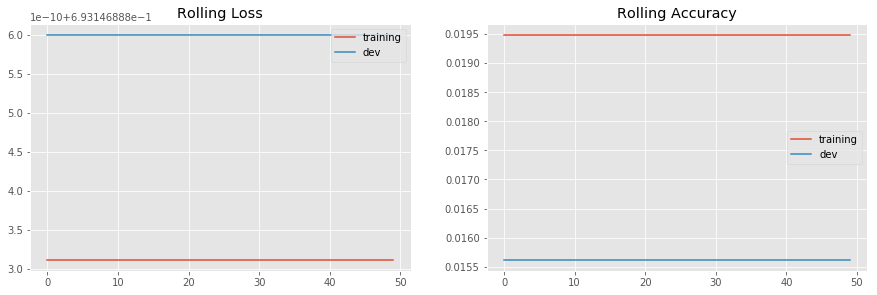

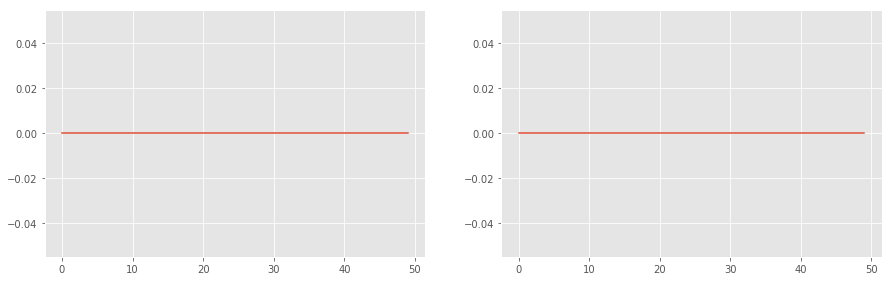

In [38]:
#### RUN MODEL
epochs = 50
lr_rate = 0.0001
dev_rolling_loss,dev_rolling_acc,test_precision,test_recall,model = train_net(train_loader,dev_loader,lr_rate)

In [32]:
shap.initjs()
explainer = shap.DeepExplainer(model,df)
shap_values = explainer.shap_values(df)

shap.summary_plot(shap_values, features=df)

NameError: name 'shap' is not defined

In [20]:
infile = open("model_1.pkl",'rb')
saved_model = pickle.load(infile)
infile.close()

AttributeError: Can't get attribute '_rebuild_parameter' on <module 'torch._utils' from 'C:\\Users\\BingLesleyYuan\\Anaconda3\\lib\\site-packages\\torch\\_utils.py'>

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\BingLesleyYuan\Anaconda3\lib\site-packages\torch\nn\functional.py:1474: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\BingLesleyYuan\Anaconda3\lib\site-packages\torch\nn\functional.py:1474: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\BingLesleyYuan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bi

Train Loss:  0.6931468883118073 , Test Loss:  0.6931468885998393
Train Accuracy:  0.020089285714285716 , Test Accuracy:  0.015625
Precision:  0.0 , Recall:  0.0


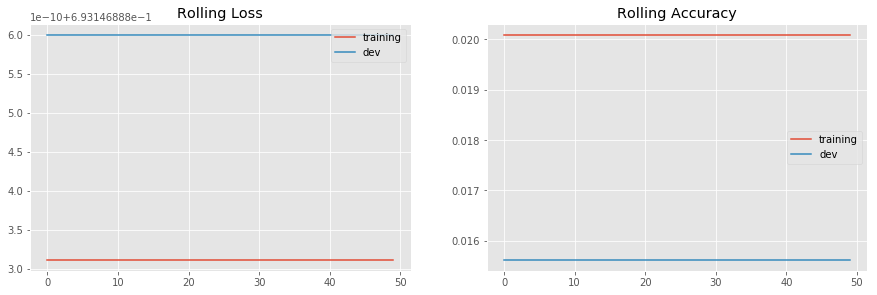

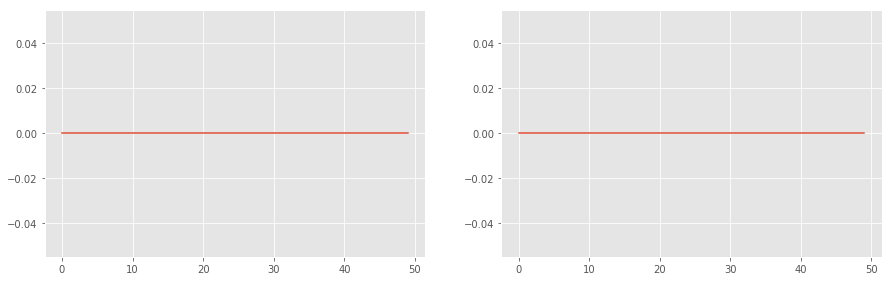

100%|██████████| 50/50 [03:02<00:00,  3.64s/it]


Train Loss:  0.01364371556271643 , Test Loss:  0.011136920472566203
Train Accuracy:  0.9618950385551948 , Test Accuracy:  0.9702943313953488
Precision:  0.9996366279069767 , Recall:  1.0


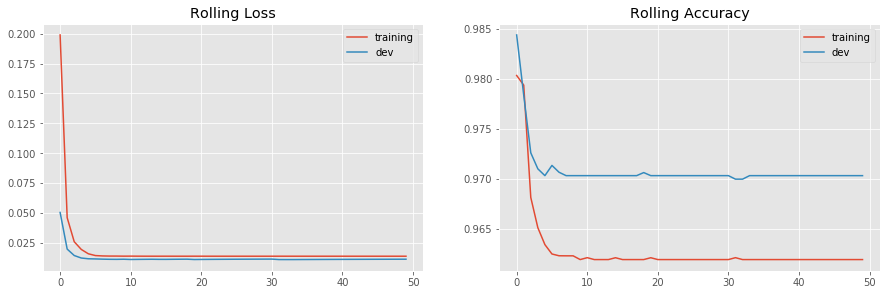

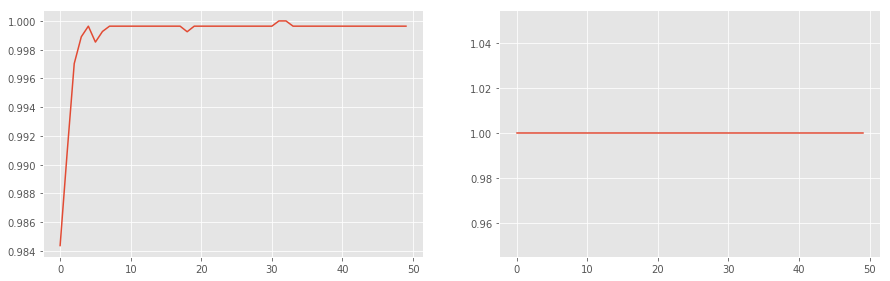

100%|██████████| 50/50 [02:54<00:00,  3.50s/it]


Train Loss:  0.013784594721237681 , Test Loss:  0.010842711599833976
Train Accuracy:  0.961520900974026 , Test Accuracy:  0.9702489098837209
Precision:  0.9996124031007753 , Recall:  1.0


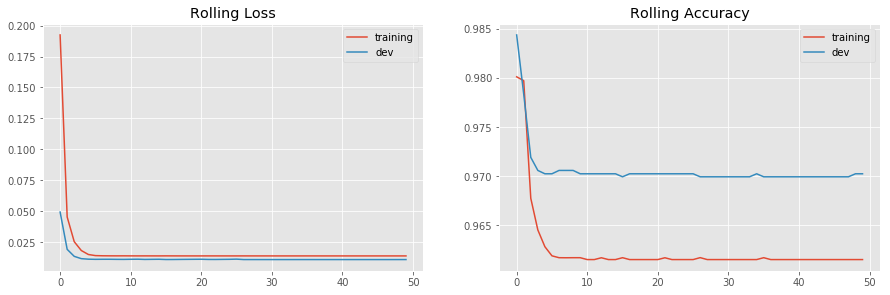

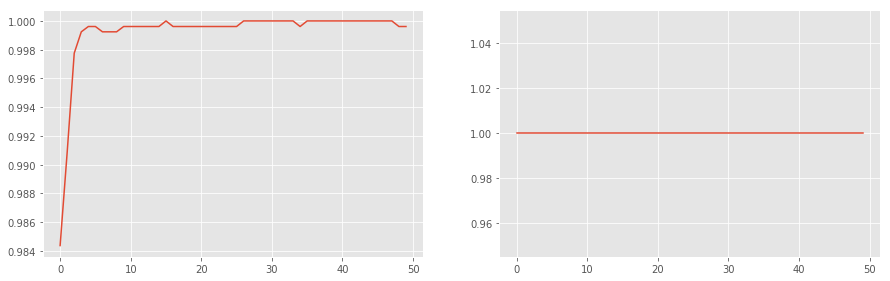

100%|██████████| 50/50 [02:58<00:00,  3.56s/it]


Train Loss:  0.013362825281452575 , Test Loss:  0.010830985211435048
Train Accuracy:  0.9626686789772727 , Test Accuracy:  0.9699423146802325
Precision:  1.0 , Recall:  1.0


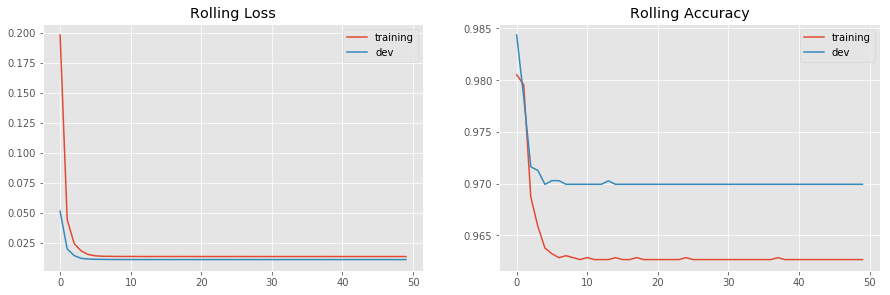

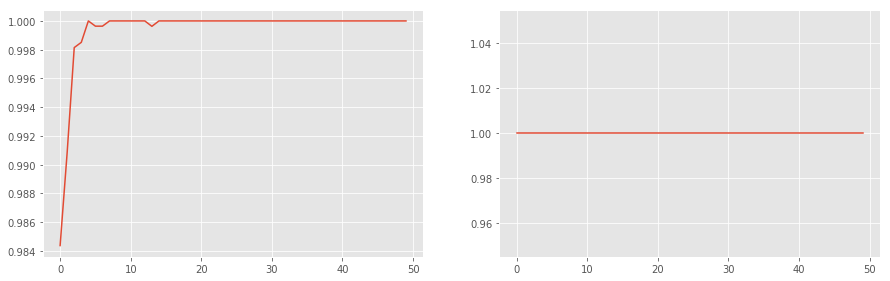

100%|██████████| 50/50 [02:51<00:00,  3.43s/it]


Train Loss:  0.013661263179608949 , Test Loss:  0.010849049724906445
Train Accuracy:  0.9621233258928571 , Test Accuracy:  0.9699423146802325
Precision:  1.0 , Recall:  1.0


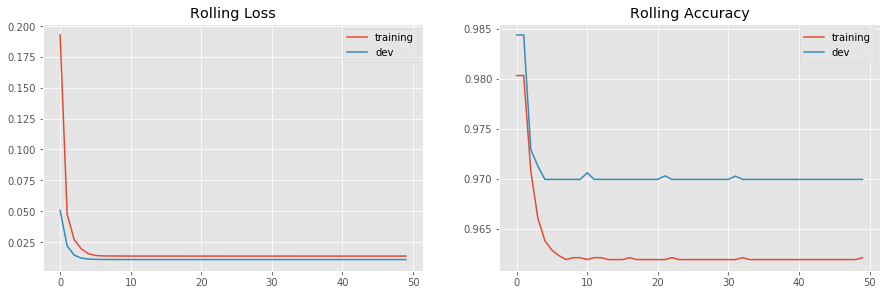

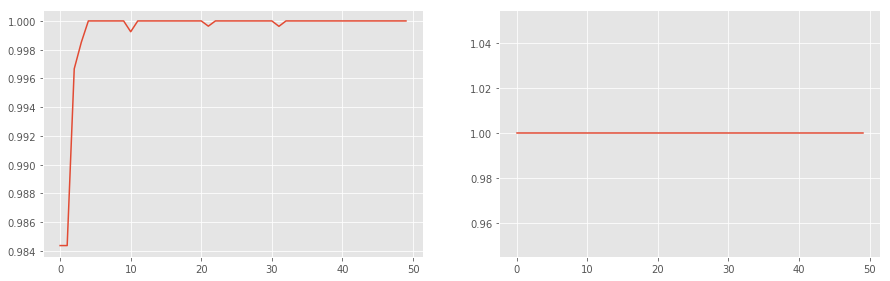

100%|██████████| 50/50 [02:54<00:00,  3.50s/it]


Train Loss:  0.013925268157619117 , Test Loss:  0.011708057723716577
Train Accuracy:  0.9611594460227273 , Test Accuracy:  0.9706122819767442
Precision:  0.9992557663225331 , Recall:  1.0


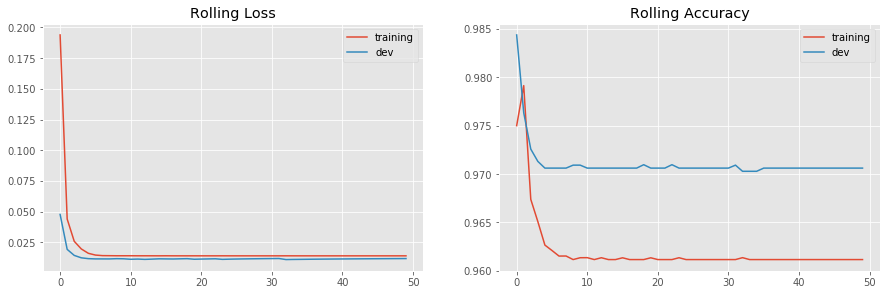

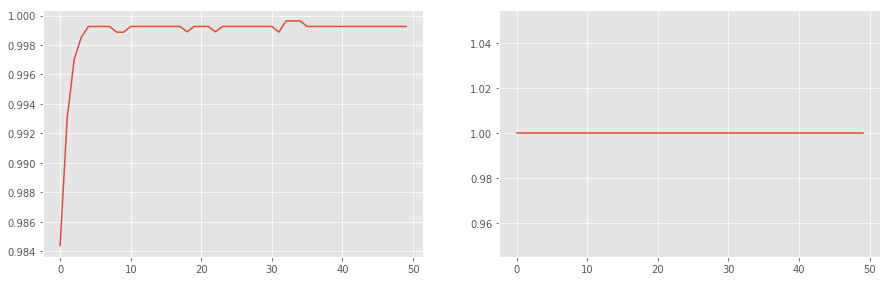

100%|██████████| 50/50 [02:55<00:00,  3.51s/it]


Train Loss:  0.013362655796416075 , Test Loss:  0.010830819607225178
Train Accuracy:  0.962694044237013 , Test Accuracy:  0.9699423146802325
Precision:  1.0 , Recall:  1.0


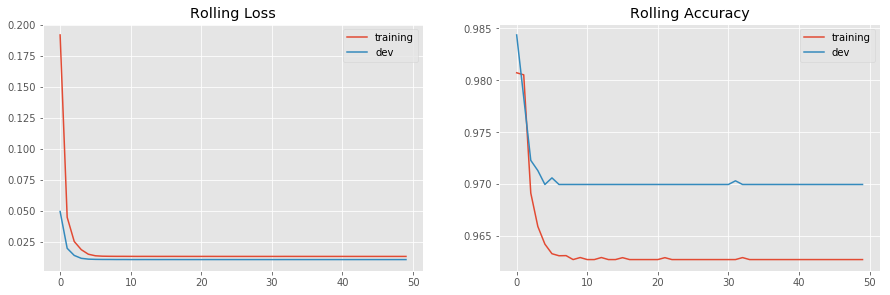

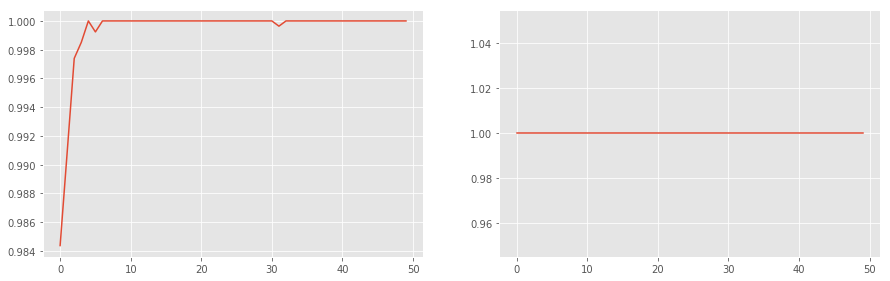

100%|██████████| 50/50 [02:06<00:00,  2.53s/it]


Train Loss:  0.6931468883118073 , Test Loss:  0.6931468885998393
Train Accuracy:  0.020495129870129872 , Test Accuracy:  0.015625
Precision:  0.0 , Recall:  0.0


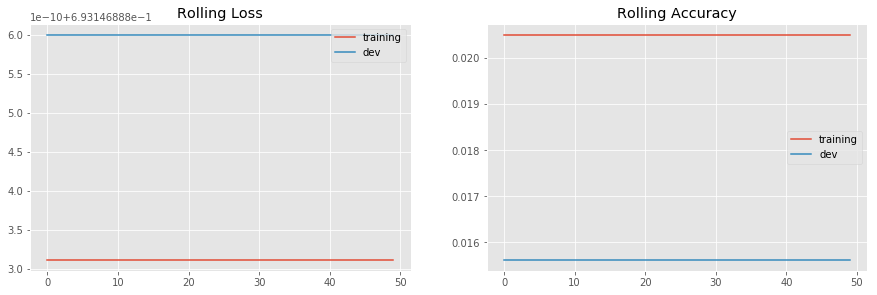

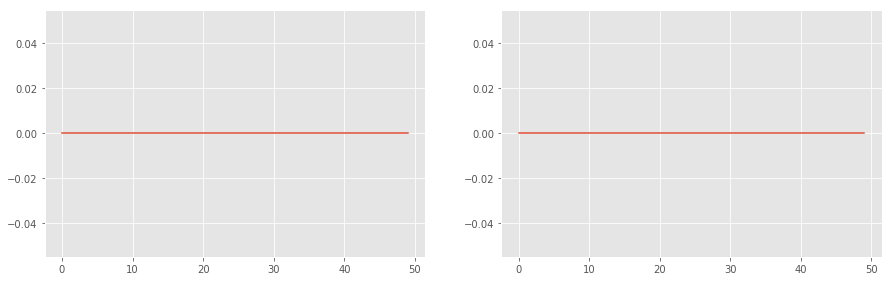

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\BingLesleyYuan\Anaconda3\lib\site-packages\torch\nn\functional.py:1474: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
100%|██████████| 50/50 [02:58<00:00,  3.57s/it]


Train Loss:  0.014628636009953913 , Test Loss:  0.010830803233141445
Train Accuracy:  0.9591619318181818 , Test Accuracy:  0.9699423146802325
Precision:  1.0 , Recall:  1.0


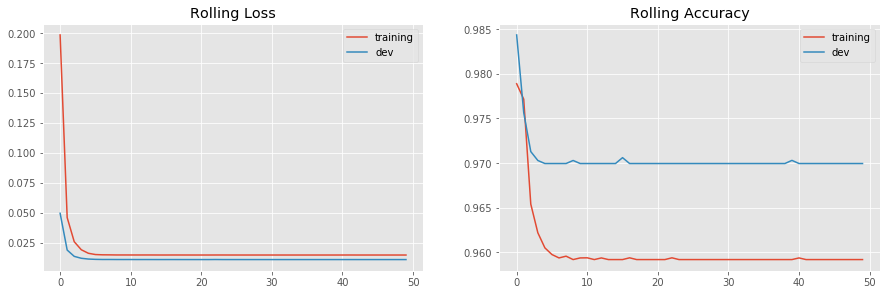

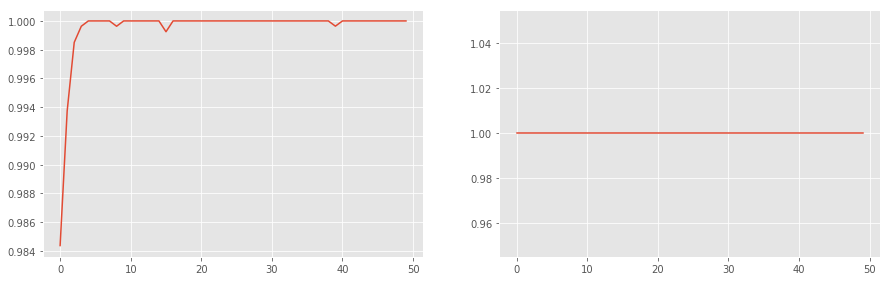

100%|██████████| 50/50 [02:46<00:00,  3.33s/it]


Train Loss:  0.013504222863344597 , Test Loss:  0.010831454435756088
Train Accuracy:  0.9622945413961039 , Test Accuracy:  0.9699423146802325
Precision:  1.0 , Recall:  1.0


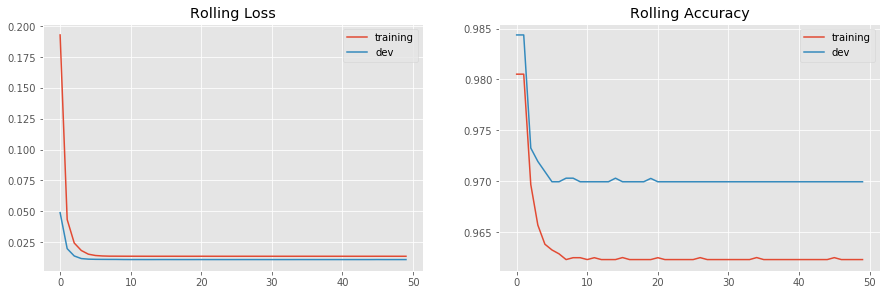

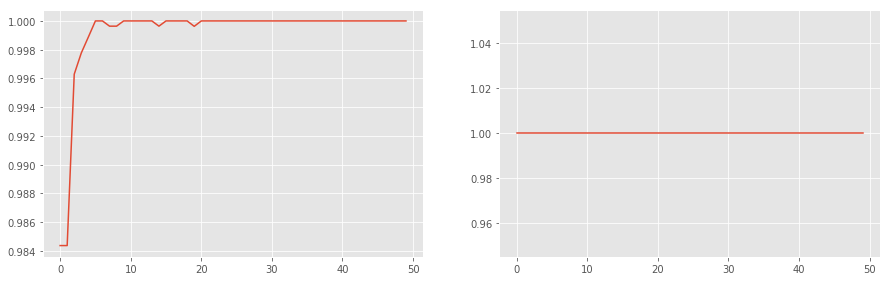

In [33]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10)

cv_results = {}

for fold, (train_index, test_index) in enumerate(kfold.split(x, y)):
        ### Dividing data into folds
    x_train_fold = x[train_index]
    x_test_fold = x[test_index]
    y_train_fold = y[train_index]
    y_test_fold = y[test_index]

    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    test = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
    cv_results[fold] = train_net(train_loader,dev_loader,lr_rate)

In [34]:
print("Fold\tBCE Loss\tAccuracy\tPrecision\tRecall")
for k,v in cv_results.items():
    print(k,"\t", round(v[0][-1],5),"\t",round(v[1][-1],5),"\t",round(v[2][-1],5),"\t",round(v[3][-1],5))

Fold	BCE Loss	Accuracy	Precision	Recall
0 	 0.69315 	 0.01562 	 0.0 	 0.0
1 	 0.01114 	 0.97029 	 0.99964 	 1.0
2 	 0.01084 	 0.97025 	 0.99961 	 1.0
3 	 0.01083 	 0.96994 	 1.0 	 1.0
4 	 0.01085 	 0.96994 	 1.0 	 1.0
5 	 0.01171 	 0.97061 	 0.99926 	 1.0
6 	 0.01083 	 0.96994 	 1.0 	 1.0
7 	 0.69315 	 0.01562 	 0.0 	 0.0
8 	 0.01083 	 0.96994 	 1.0 	 1.0
9 	 0.01083 	 0.96994 	 1.0 	 1.0


In [35]:
print("Fold\tBCE Loss\tAccuracy\tPrecision\tRecall")
for k,v in cv_results.items():
    print(k,"\t", round(v[0][-1],5),"\t",round(v[1][-1],5),"\t",round(v[2][-1],5),"\t",round(v[3][-1],5))

Fold	BCE Loss	Accuracy	Precision	Recall
0 	 0.69315 	 0.01562 	 0.0 	 0.0
1 	 0.01114 	 0.97029 	 0.99964 	 1.0
2 	 0.01084 	 0.97025 	 0.99961 	 1.0
3 	 0.01083 	 0.96994 	 1.0 	 1.0
4 	 0.01085 	 0.96994 	 1.0 	 1.0
5 	 0.01171 	 0.97061 	 0.99926 	 1.0
6 	 0.01083 	 0.96994 	 1.0 	 1.0
7 	 0.69315 	 0.01562 	 0.0 	 0.0
8 	 0.01083 	 0.96994 	 1.0 	 1.0
9 	 0.01083 	 0.96994 	 1.0 	 1.0


In [39]:
print("Fold\tBCE Loss\tAccuracy\tPrecision\tRecall")
for k,v in cv_results.items():
    print(k,"\t", round(v[0][-1],5),"\t",round(v[1][-1],5),"\t",round(v[2][-1],5),"\t",round(v[3][-1],5))

Fold	BCE Loss	Accuracy	Precision	Recall
0 	 0.69315 	 0.01562 	 0.0 	 0.0
1 	 0.01114 	 0.97029 	 0.99964 	 1.0
2 	 0.01084 	 0.97025 	 0.99961 	 1.0
3 	 0.01083 	 0.96994 	 1.0 	 1.0
4 	 0.01085 	 0.96994 	 1.0 	 1.0
5 	 0.01171 	 0.97061 	 0.99926 	 1.0
6 	 0.01083 	 0.96994 	 1.0 	 1.0
7 	 0.69315 	 0.01562 	 0.0 	 0.0
8 	 0.01083 	 0.96994 	 1.0 	 1.0
9 	 0.01083 	 0.96994 	 1.0 	 1.0
